### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается построить модель многоклассовой классификации для показателя `RiskVar`. Воспользуемся другими частями датасета freMPL (1 и 2).

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval, STATUS_OK, Trials
from hyperopt.fmin import fmin

def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [2]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [3]:
df = df.loc[df.Dataset.isin([1, 2])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
pd.set_option('display.max_columns', 100)

In [5]:
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,ClaimAmount,RiskVar,Garage,ClaimInd
0,0.583,366,2004-06-01,NaN,2,Female,Other,CSP1,Professional,55,0,72,sedan,D,injection,regular,160-170 km/h,B,0.000000,15.0,None,0
1,0.200,187,2004-10-19,NaN,0,Male,Alone,CSP55,Private+trip to office,34,0,80,microvan,K,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,20.0,None,0
2,0.083,169,2004-07-16,2004-08-16,1,Female,Other,CSP1,Professional,33,0,63,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,None,0
3,0.375,170,2004-08-16,NaN,1,Female,Other,CSP1,Professional,34,0,63,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,Private garage,0
4,0.500,224,2004-01-01,2004-07-01,3,Male,Other,CSP47,Professional,53,0,72,van,L,direct injection overpowered,diesel,140-150 km/h,0,1418.610272,19.0,None,1


Предобработайте данные

In [6]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Female', 1: 'Male'}


In [7]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


In [8]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [9]:
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

In [10]:
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,ClaimAmount,RiskVar,Garage,ClaimInd,VehUsage_Private,VehUsage_Private+trip to office,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,SocioCateg_CSP9
0,0.583,366,2004-06-01,NaN,2,0,0,55,0,72,sedan,D,injection,regular,160-170 km/h,B,0.000000,15.0,None,0,0,0,1,0,1,0,0,0,0,0,0,0
1,0.200,187,2004-10-19,NaN,0,1,1,34,0,80,microvan,K,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,20.0,None,0,0,1,0,0,0,0,0,0,1,0,0,0
2,0.083,169,2004-07-16,2004-08-16,1,0,0,33,0,63,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,None,0,0,0,1,0,1,0,0,0,0,0,0,0
3,0.375,170,2004-08-16,NaN,1,0,0,34,0,63,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,Private garage,0,0,0,1,0,1,0,0,0,0,0,0,0
4,0.500,224,2004-01-01,2004-07-01,3,1,0,53,0,72,van,L,direct injection overpowered,diesel,140-150 km/h,0,1418.610272,19.0,None,1,0,0,1,0,0,0,0,1,0,0,0,0


In [11]:
df.select_dtypes('object')

,RecordBeg,RecordEnd,VehAge,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,Garage
0,2004-06-01,NaN,2,sedan,D,injection,regular,160-170 km/h,B,None
1,2004-10-19,NaN,0,microvan,K,direct injection overpowered,diesel,170-180 km/h,M1,None
2,2004-07-16,2004-08-16,1,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,None
3,2004-08-16,NaN,1,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,Private garage
4,2004-01-01,2004-07-01,3,van,L,direct injection overpowered,diesel,140-150 km/h,0,None
...,...,...,...,...,...,...,...,...,...,...
40727,2004-09-01,NaN,10+,sedan,C,carburation,regular,140-150 km/h,B,None
40728,2004-01-01,2004-04-25,5,sedan,J,direct injection overpowered,diesel,170-180 km/h,M2,None
40729,2004-04-25,NaN,6-7,sedan,J,direct injection overpowered,diesel,170-180 km/h,M2,None
40730,2004-01-01,2004-07-01,10+,sedan,K,injection overpowered,diesel,170-180 km/h,M2,None


In [12]:
df['RecordBeg'] = pd.to_datetime(df['RecordBeg'], format='%Y-%m-%d')

In [13]:
df.drop('RecordBeg', inplace=True, axis=1)

In [14]:
df.drop('RecordEnd', inplace=True, axis=1)

In [15]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

In [16]:
df['VehPrice'] = df.VehPrice.str.slice(0,1)

In [17]:
df['VehPrice'] = [ ord(x) - 64 for x in df['VehPrice'] ]

In [18]:
categ_columns = df.select_dtypes('object').columns

In [19]:
categ_columns

Index(['VehAge', 'VehBody', 'VehEngine', 'VehEnergy', 'VehMaxSpeed',
       'VehClass', 'Garage'],
      dtype='object')

In [20]:
df = pd.get_dummies(df, columns=categ_columns)

In [21]:
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,VehPrice,ClaimAmount,RiskVar,ClaimInd,VehUsage_Private,VehUsage_Private+trip to office,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,SocioCateg_CSP9,VehAge_0,VehAge_1,VehAge_10+,VehAge_2,VehAge_3,VehAge_4,VehAge_5,VehAge_6-7,VehAge_8-9,VehBody_bus,VehBody_cabriolet,VehBody_coupe,VehBody_microvan,VehBody_other microvan,VehBody_sedan,VehBody_sport utility vehicle,VehBody_station wagon,VehBody_van,VehEngine_GPL,VehEngine_carburation,VehEngine_direct injection overpowered,VehEngine_electric,VehEngine_injection,VehEngine_injection overpowered,VehEnergy_GPL,VehEnergy_diesel,VehEnergy_eletric,VehEnergy_regular,VehMaxSpeed_1-130 km/h,VehMaxSpeed_130-140 km/h,VehMaxSpeed_140-150 km/h,VehMaxSpeed_150-160 km/h,VehMaxSpeed_160-170 km/h,VehMaxSpeed_170-180 km/h,VehMaxSpeed_180-190 km/h,VehMaxSpeed_190-200 km/h,VehMaxSpeed_200-220 km/h,VehMaxSpeed_220+ km/h,VehClass_0,VehClass_A,VehClass_B,VehClass_H,VehClass_M1,VehClass_M2,Garage_Collective garage,Garage_None,Garage_Private garage
0,0.583,366,0,0,55,0,72,4,0.000000,15.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0.200,187,1,1,34,0,80,11,0.000000,20.0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0.083,169,0,0,33,0,63,12,0.000000,17.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0.375,170,0,0,34,0,63,12,0.000000,17.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
4,0.500,224,1,0,53,0,72,12,1418.610272,19.0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40732 entries, 0 to 40731
Data columns (total 70 columns):
Exposure                                  40732 non-null float64
LicAge                                    40732 non-null int64
Gender                                    40732 non-null int64
MariStat                                  40732 non-null int64
DrivAge                                   40732 non-null int64
HasKmLimit                                40732 non-null int64
BonusMalus                                40732 non-null int64
VehPrice                                  40732 non-null int64
ClaimAmount                               40732 non-null float64
RiskVar                                   40732 non-null float64
ClaimInd                                  40732 non-null int64
VehUsage_Private                          40732 non-null uint8
VehUsage_Private+trip to office           40732 non-null uint8
VehUsage_Professional                     40732 non-null uint8
Veh

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Поэтому, вычтем из значений переменной `RiskVar` единицу.

In [23]:
df['RiskVar'] = df['RiskVar'] -1

Данная переменная принимает значения от 1 до 20, которые, возможно, упорядочены. Посмотрим, сколько полисов соответствуют каждому из значений `RiskVar`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [24]:
FreqCount = pd.DataFrame(df.groupby('RiskVar')['RiskVar'].count().to_frame().rename(columns={'RiskVar': 'Count'}),
                         columns=['Count'])
FreqCount['Freq'] = FreqCount['Count'] / FreqCount['Count'].sum()

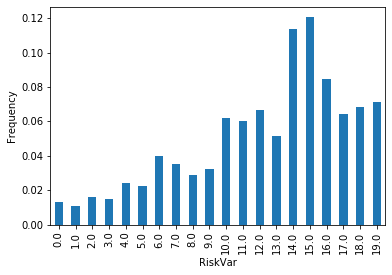

In [25]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [26]:
FreqCount

,Count,Freq
RiskVar,,
0.0,531,0.013036
1.0,451,0.011072
2.0,660,0.016203
3.0,603,0.014804
4.0,979,0.024035
5.0,902,0.022145
6.0,1634,0.040116
7.0,1439,0.035328
8.0,1170,0.028724


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.5` для значений `RiskVar` 14 и 15, а для остальных - 1 (Для этого можем использовать функцию `np.where` и метод `isin` для `pandas.Series`). Также можно попробовать какой-либо другой способ задания весов.

In [27]:
df['weight'] = 1

In [28]:
df.loc[df['RiskVar'].isin([14, 15]), 'weight'] = 0.5

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [29]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('RiskVar', axis=1), df.RiskVar, test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [30]:
xgb_train = xgb.DMatrix(x_train.drop(['weight'], axis=1), (y_train), weight=x_train.weight)
xgb_valid = xgb.DMatrix(x_valid.drop(['weight'], axis=1), (y_valid))
xgb_test = xgb.DMatrix(x_test.drop(['weight'], axis=1), (y_test))

C:\Users\alibe\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\alibe\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Для оптимизации гиперпараметров можно воспользоваться различными методами. Однако, в случае Hyperopt, на процесс подбора гиперпараметров может уйти немалое количество часов.

In [36]:
def objective(space):
    # Instantiate the classifier
    clf = xgb.XGBClassifier(n_estimators = 250,
                           max_depth = int(space['max_depth']),
                           min_child_weight = space['min_child_weight'],
                           colsample_bytree = space['colsample_bytree'],
                           alpha = space['alpha'],
                           eta = space['eta'], 
                           num_class = 20,
                           n_jobs = -1, 
                           objective = 'multi:softprob')
    
    eval_set  = [(x_train, y_train), (x_valid, y_valid)]
    
    # Fit the classsifier
    clf.fit(x_train, y_train,
            eval_set=eval_set, eval_metric="mlogloss",
            early_stopping_rounds=10,verbose=False)
    
    # Predict on Cross Validation data
    pred = clf.predict(x_valid)
    
    # Calculate our Metric - accuracy
    accuracy = accuracy_score(y_valid, pred>0.5)
    # return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': -accuracy, 'status': STATUS_OK }

In [37]:
space ={'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
         'min_child_weight': hp.uniform('min_child_weight', 0, 50),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'alpha': hp.uniform('alpha', 0, 1),
         'eta': hp.uniform('eta', 0.01, 1),
    }

In [39]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)
print(best)

100%|██████████████████████████████████████████| 10/10 [1:10:57<00:00, 425.75s/trial, best loss: -0.013256955810147299]
{'alpha': 0.005788072364623198, 'colsample_bytree': 0.7086125068802352, 'eta': 0.7758044635741713, 'max_depth': 0, 'min_child_weight': 2.372270833972012, 'subsample': 0.7294849685533726}


In [41]:
best_params = space_eval(space, best)
best_params['objective'] = 'multi:softprob'
best_params['num_class'] = 20
best_params['max_depth'] = int(best_params['max_depth'])
best_params

{'alpha': 0.005788072364623198,
 'colsample_bytree': 0.7086125068802352,
 'eta': 0.7758044635741713,
 'max_depth': 5,
 'min_child_weight': 2.372270833972012,
 'subsample': 0.7294849685533726,
 'objective': 'multi:softprob',
 'num_class': 20}

Далее обучим нашу модель с оптимальными параметрами

In [43]:
# Построение модели с ранней остановкой (early stopping)

xgb_risk = xgb.XGBClassifier(n_estimators = 1000, params = best_params, n_jobs = -1)
eval_set  = [(x_train, y_train), (x_valid, y_valid)]
xgb_risk.fit(x_train, y_train,
            eval_set=eval_set, eval_metric="mlogloss",
            early_stopping_rounds=10,verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob',
              params={'alpha': 0.005788072364623198,
                      'colsample_bytree': 0.7086125068802352,
                      'eta': 0.7758044635741713, 'max_depth': 5,
                      'min_child_weight': 2.372270833972012, 'num_class': 20,
                      'objective': 'multi:softprob',
                      'subsample': 0.7294849685533726},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [44]:
# Построение модели без ранней остановки

xgb_risk_wo_es = xgb.XGBClassifier(n_estimators = 1000, params = best_params, n_jobs = -1)
eval_set  = [(x_train, y_train), (x_valid, y_valid)]
xgb_risk_wo_es.fit(x_train, y_train,
            eval_set=eval_set, eval_metric="mlogloss",
            verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob',
              params={'alpha': 0.005788072364623198,
                      'colsample_bytree': 0.7086125068802352,
                      'eta': 0.7758044635741713, 'max_depth': 5,
                      'min_child_weight': 2.372270833972012, 'num_class': 20,
                      'objective': 'multi:softprob',
                      'subsample': 0.7294849685533726},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [49]:
dfsets = [{'set': 'train', 'dmat': x_train, 'target': y_train},
          {'set': 'valid', 'dmat': x_valid, 'target': y_valid},
          {'set': 'test', 'dmat': x_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = xgb_risk_wo_es.predict(dfset["dmat"]) # Посчитаем предсказанные значения
    print('F1 Score on ' + str(dfset['set'])+':', 
          f1_score(dfset["target"], class_preds, average='micro')) # Посчитаем F1 Score
    print('Accuracy Score on ' + str(dfset['set'])+':', 
          accuracy_score(dfset["target"], class_preds)) # Посчитаем Accuracy Score
    print('\n')

F1 Score on train: 0.5443322109988776
Accuracy Score on train: 0.5443322109988776


F1 Score on valid: 0.3032733224222586
Accuracy Score on valid: 0.3032733224222586


F1 Score on test: 0.3029459901800327
Accuracy Score on test: 0.3029459901800327




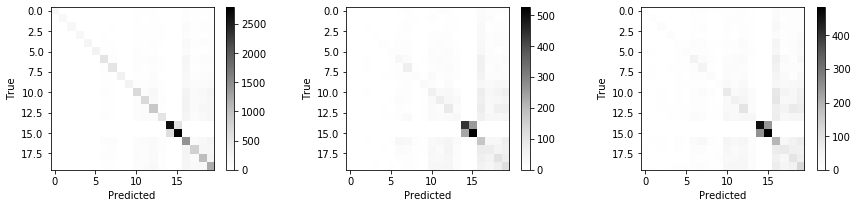

In [50]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_risk_wo_es.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

Качество модели получилось низким, Accuracy Score порядка 50%